### Numeric Variables
The simplest way to describe each numeric variable is through its five-number summary, inspecting its range through the identification of its minimum and maximum values, along with other estimators, like the mean, standard deviation and other different percentiles.

In [1]:
import sys
sys.path.insert(1, '../utils')
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data = data.astype({'anaemia': bool, 'diabetes': bool, 'high_blood_pressure': bool, 'sex': bool, 'smoking': bool, 'DEATH_EVENT': bool})

#---------------------------------------------------------------------#

data.describe().append(data.select_dtypes(include='number').mode()[:1]).rename({0: 'mode'}, axis='index')

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000
mode,60.000000,582.000000,35.000000,263358.030000,1.00000,136.000000,187.000000


The five-numbers summary alone, give all the information required, but it's not easy to interpret. A better way to understand the impact of such values is through the analysis of boxplots for each variable.

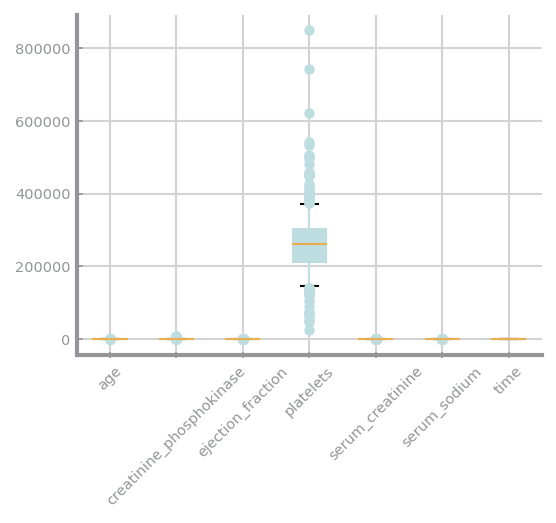

In [2]:
data.boxplot(column=data.select_dtypes(include='number').columns.tolist(), rot=45)
plt.show()

Due to the different scales it is difficult to analyze each one in particular ploting all numeric variables in the same chart. So we will plot singular boxplots for each variable

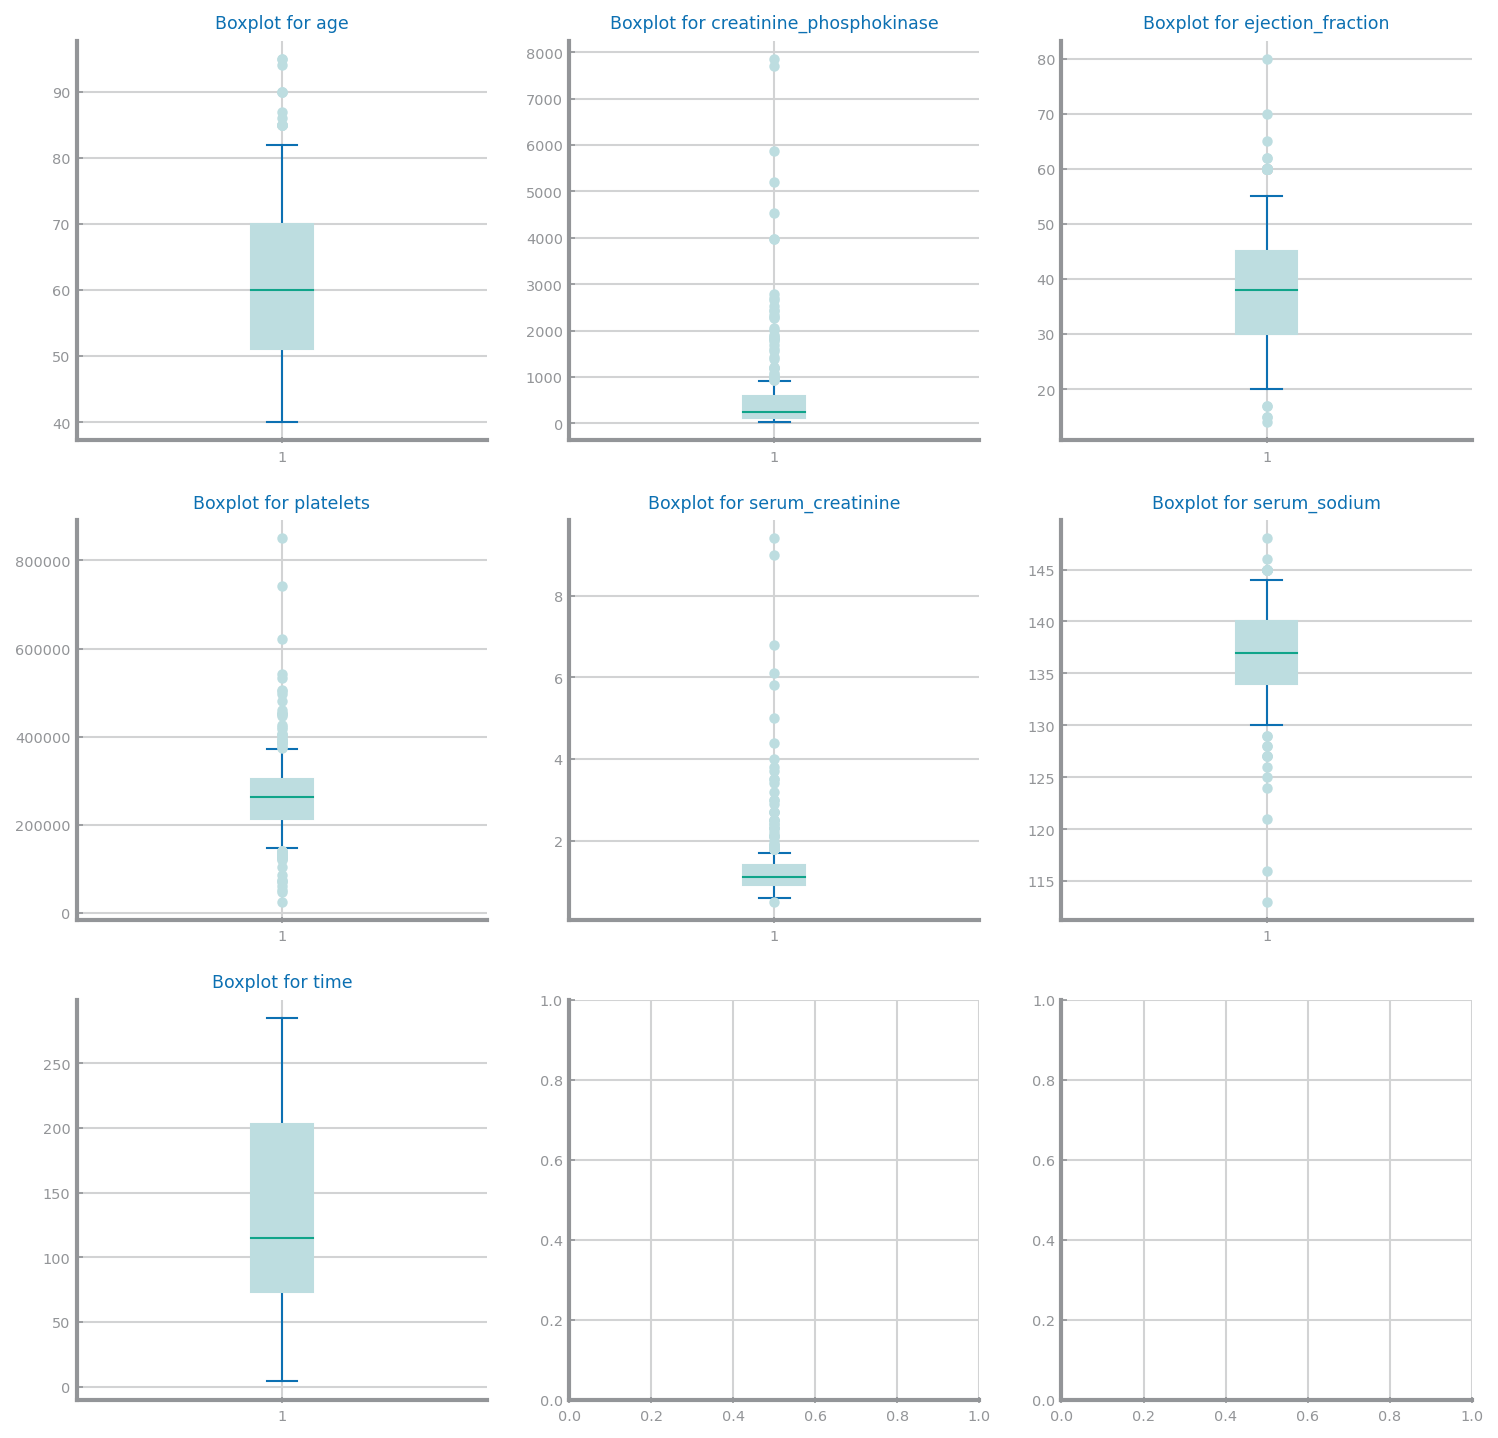

In [3]:
numeric_vars = data.select_dtypes(include='number').columns
rows, cols = ds.choose_grid(len(numeric_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
    axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

It's clear that our variables have different ranges, scales, that there are several outliers, etc, but we are not able to know anything else about the variables distribution. In order to see their distribution the best option is to plot the histogram for each numeric variable.

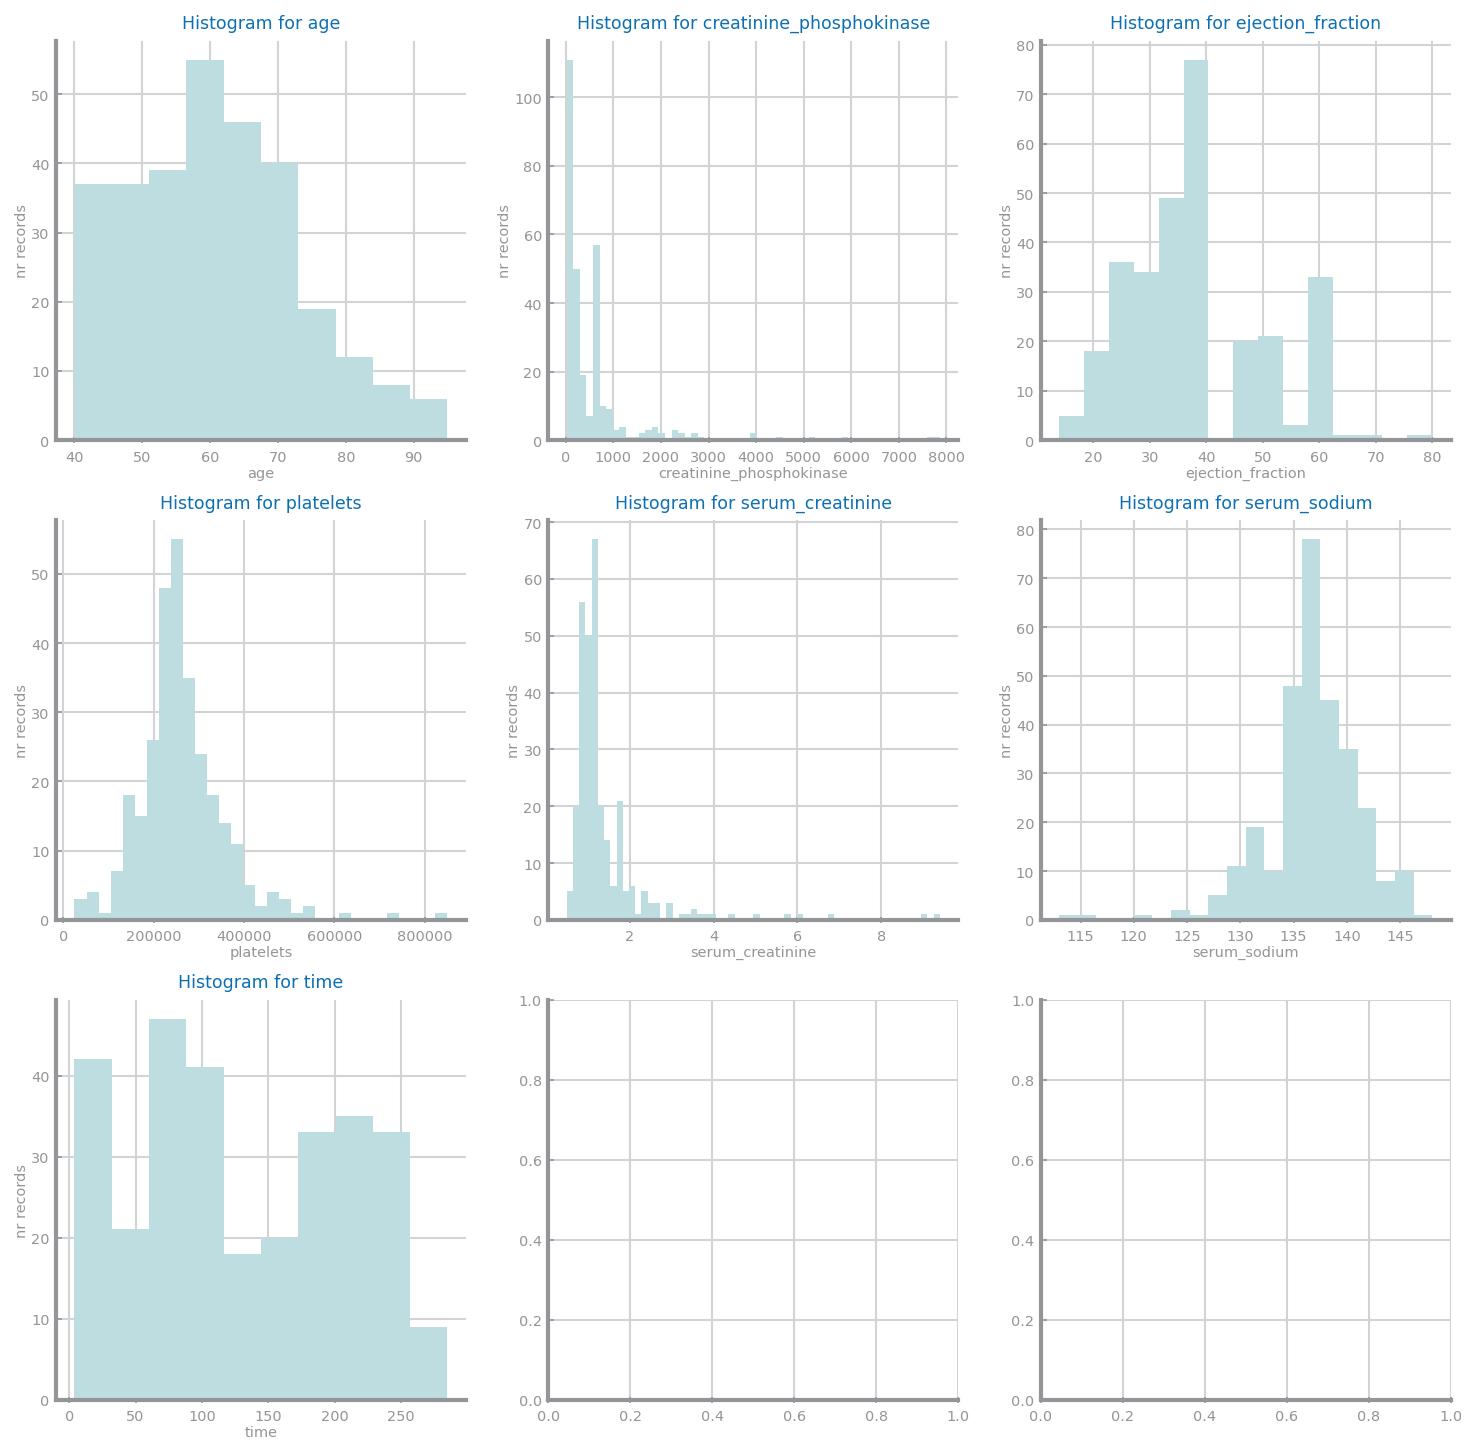

In [4]:
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Histogram for %s'%numeric_vars[n])
    axs[i, j].set_xlabel(numeric_vars[n])
    axs[i, j].set_ylabel("nr records")
    axs[i, j].hist(data[numeric_vars[n]].dropna().values, 'auto')
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

Indeed histograms give us an insight about the distribution of each variable. Lets try to fit different known distributions to it.

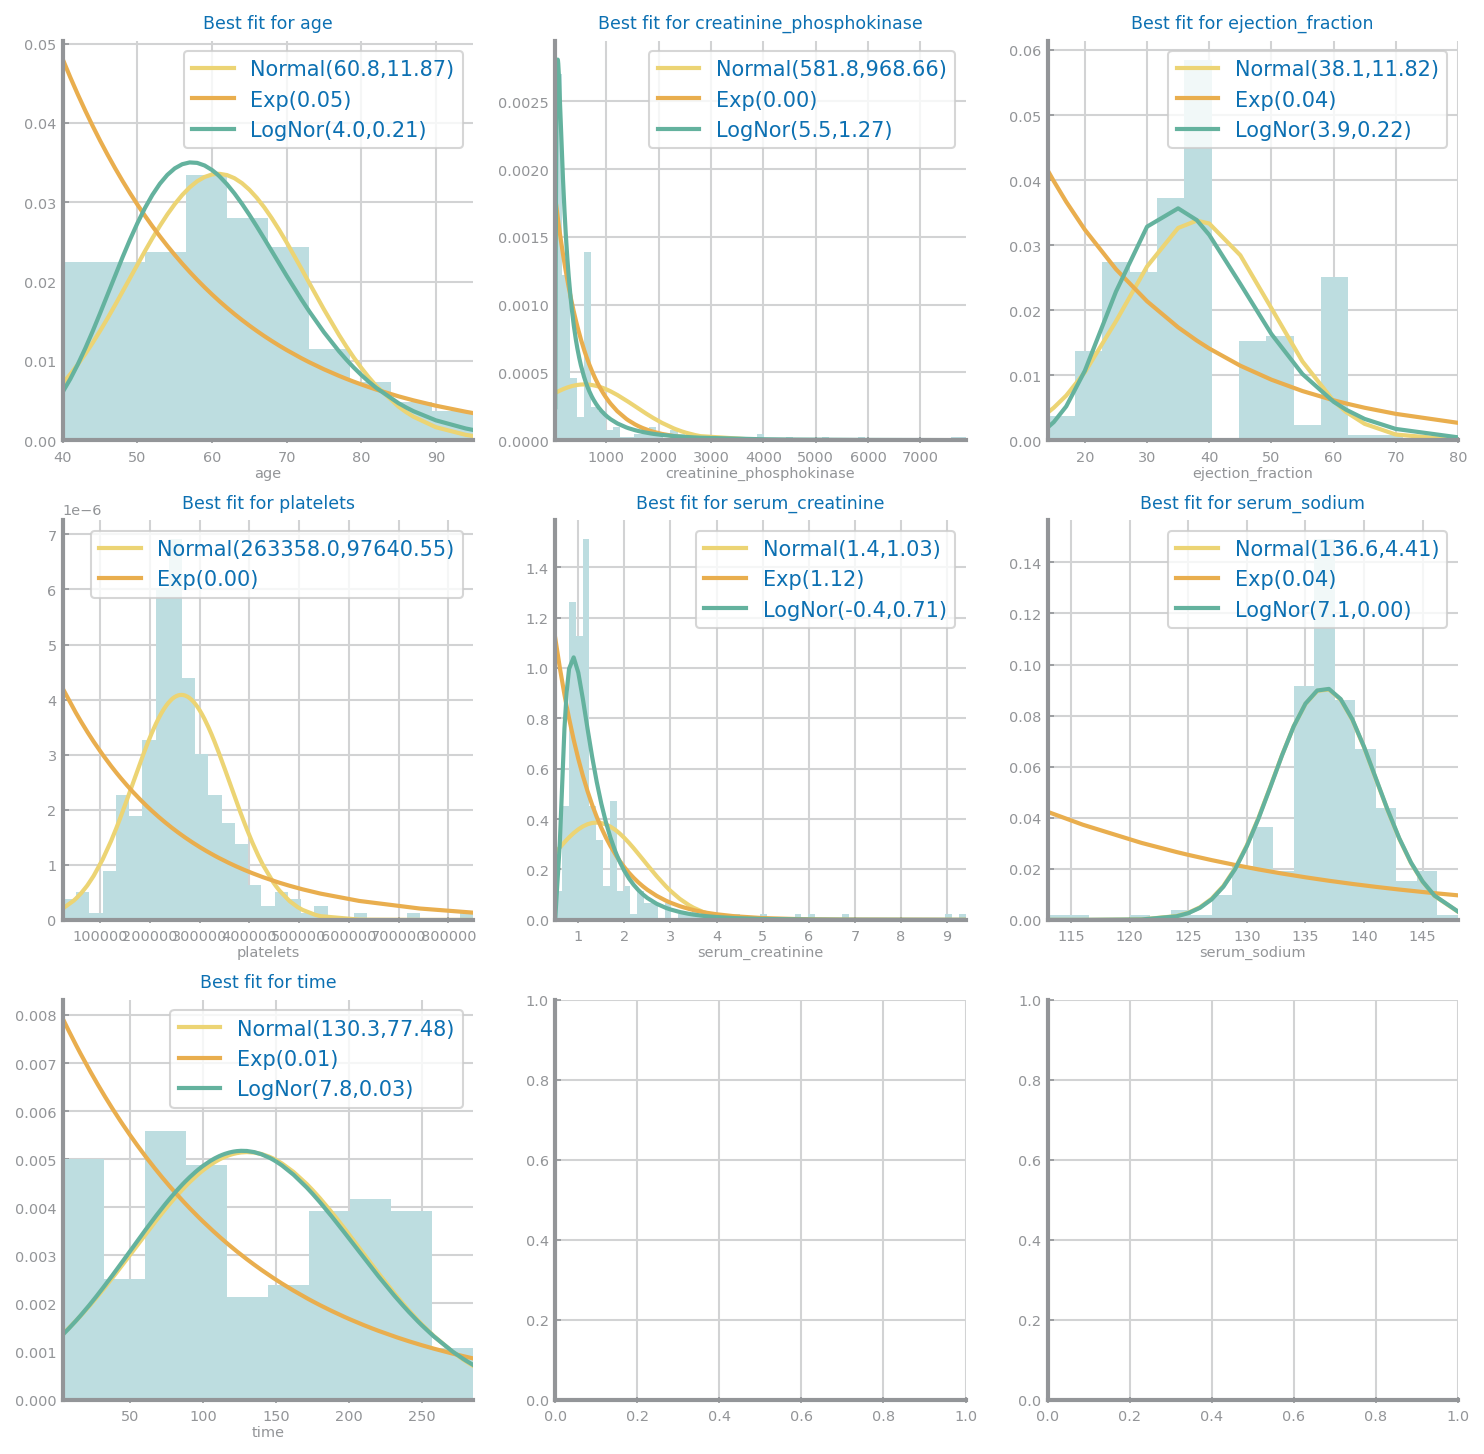

In [5]:
'''
import seaborn as sns
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Histogram with trend for %s'%numeric_vars[n])
    sns.distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()
'''
import scipy.stats as _stats
import numpy as np
def compute_known_distributions(x_values: list, useLogNorm: bool = True) -> dict:
    distributions = dict()
    # Gaussian
    mean, sigma = _stats.norm.fit(x_values)
    distributions['Normal(%.1f,%.2f)'%(mean,sigma)] = _stats.norm.pdf(x_values, mean, sigma)
    # Exponential
    loc, scale = _stats.expon.fit(x_values)
    distributions['Exp(%.2f)'%(1/scale)] = _stats.expon.pdf(x_values, loc, scale)
    # LogNorm
    if useLogNorm:
        sigma, loc, scale = _stats.lognorm.fit(x_values)
        distributions['LogNor(%.1f,%.2f)'%(np.log(scale),sigma)] = _stats.lognorm.pdf(x_values, sigma, loc, scale)
    return distributions

def histogram_with_distributions(ax: plt.Axes, series: pd.Series, var: str):
    values = series.sort_values().values
    ax.hist(values, 'auto', density=True)
    distributions = compute_known_distributions(values, var != 'platelets')
    ds.multiple_line_chart(values, distributions, ax=ax, title='Best fit for %s'%var, xlabel=var, ylabel='')

fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    histogram_with_distributions(axs[i, j], data[numeric_vars[n]].dropna(), numeric_vars[n])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    
plt.show()

### Symbolic Variables
Boxplots are not applicable to non-numeric variables. Lets identify their values and most frequent values (modes).

In [6]:
data.describe(include='bool').rename({'top': 'mode'}, axis='index')

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299,299,299,299,299,299
unique,2,2,2,2,2,2
mode,False,False,False,True,False,False
freq,170,174,194,194,203,203


In order to explore these 6 variables, in terms of their distribution we will use histograms.

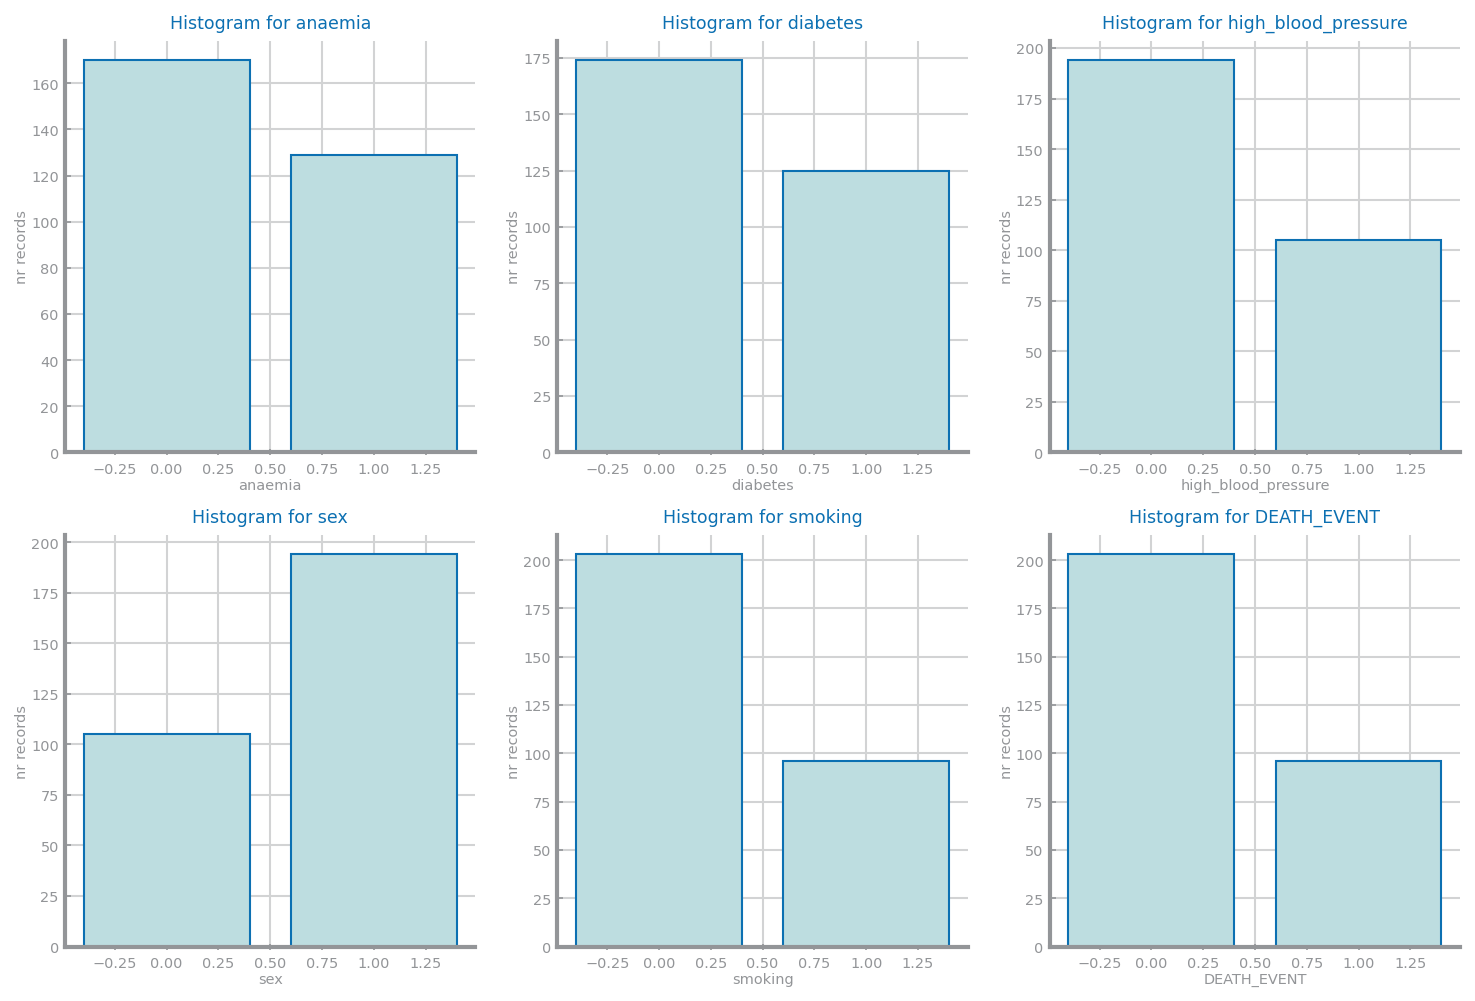

In [7]:
symbolic_vars = data.select_dtypes(include='bool').columns

rows, cols = ds.choose_grid(len(symbolic_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(symbolic_vars)):
    counts = data[symbolic_vars[n]].value_counts()
    ds.bar_chart(counts.index.to_list(), counts.values, ax=axs[i, j], title='Histogram for %s'%symbolic_vars[n],
                 xlabel=symbolic_vars[n], ylabel='nr records')
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

### Summary

***What is the type and range for each variable?***

- **age**:
    - type: Numeric
    - range[min, max]: [40, 95]
    
    
- **creatinine_phosphokinase**:
    - type: Numeric
    - range[min, max]: [23, 7861]
    
    
- **ejection_fraction**:
    - type: Numeric
    - range[min, max]: [14, 80]
    
    
- **platelets**:
    - type: Numeric
    - range[min, max]: [212500, 850000]
    
    
- **serum_creatinine**:
    - type: Numeric
    - range[min, max]: [0.5, 9.4]
    
    
- **serum_sodium**:
    - type: Numeric
    - range[min, max]: [113, 148]
    
    
- **time**:
    - type: Numeric
    - range[min, max]: [4, 285]
    
    
- **anaemia**:
    - type: Symbolic
    - range: [False, True]
    
    
- **diabetes**:
    - type: Symbolic
    - range[min, max]: [False, True]
    
    
- **high_blood_pressure**:
    - type: Symbolic
    - range[min, max]: [False, True]
    
    
- **sex**:
    - type: Symbolic
    - range[min, max]: [False, True]
    
    
- **smoking**:
    - type: Symbolic
    - range[min, max]: [False, True]
    
    
- **DEATH_EVENT**:
    - type: Symbolic
    - range[min, max]: [False, True]
        
        
***And its mean value, mode, standard deviation, and quartiles?***

- **age**:
    - mean: 60.833893
    - mode: 60
    - std: 11.894809
    - Q1: 51
    - Q2: 60
    - Q3: 70
    
    
- **creatinine_phosphokinase**:
    - mean: 581.839465
    - mode: 582
    - std: 970.287881
    - Q1: 116.5
    - Q2: 250
    - Q3: 582
    
    
- **ejection_fraction**:
    - mean: 38.083612
    - mode: 35
    - std: 11.834841
    - Q1: 30
    - Q2: 38
    - Q3: 45
    
    
- **platelets**:
    - mean: 263358.029264
    - mode: 263358.030000 (In this case the mode doesn't give much information since the variable isn't discrete)
    - std: 97804.236869
    - Q1: 212500
    - Q2: 262000
    - Q3: 303500
    
    
- **serum_creatinine**:
    - mean: 1.39388
    - mode: 1 (In this case the mode doesn't give much information since the variable isn't discrete)
    - std: 1.03451
    - Q1: 0.9
    - Q2: 1.1
    - Q3: 1.4
    
    
- **serum_sodium**:
    - mean: 136.625418
    - mode: 136
    - std: 4.412477
    - Q1: 134
    - Q2: 137
    - Q3: 140
    
    
- **time**:
    - mean: 130.260870
    - mode: 187
    - std: 77.614208
    - Q1: 73
    - Q2: 115
    - Q3: 203
    
    
- **anaemia**:
    - mode: False
    
    
- **diabetes**:
    - mode: False
    
    
- **high_blood_pressure**:
    - mode: False
    
    
- **sex**:
    - mode: True
    
    
- **smoking**:
    - mode: False
    
    
- **DEATH_EVENT**:
    - mode: False

***Are there outliers?***

Yes, every variable has outliers, except for the time variable.

***Is it possible to identify each variable distribution?***

Yes, it is possible, except for time.
- **age**:
    - distribution: Normal
    
    
- **creatinine_phosphokinase**:
    - distribution: Exponential
    
    
- **ejection_fraction**:
    - distribution: LogNorm
    
    
- **platelets**:
    - distribution: Normal
    
    
- **serum_creatinine**:
    - distribution: LogNorm
    
    
- **serum_sodium**:
    - distribution: Normal or LogNorm since the curves are overlapping
    
    
- **time**:
    - distribution: We could not find any fitting distribution.
    
    
- **anaemia**:
    - distribution: Bernoulli since it's a binary variable
    
    
- **diabetes**:
    - distribution: Bernoulli since it's a binary variable
    
    
- **high_blood_pressure**:
    - distribution: Bernoulli since it's a binary variable
    
    
- **sex**:
    - distribution: Bernoulli since it's a binary variable
    
    
- **smoking**:
    - distribution: Bernoulli since it's a binary variable
    
    
- **DEATH_EVENT**:
    - distribution: Bernoulli since it's a binary variable